In [21]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [22]:


!mkdir /kaggle/working/Corn
!mkdir /kaggle/working/Corn/test
!mkdir /kaggle/working/Corn/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Corn* /kaggle/working/Corn/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Corn* /kaggle/working/Corn/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Corn/train'
test_path='/kaggle/working/Corn/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Corn’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/train’: File exists


In [23]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*56*56, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [24]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [25]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [26]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 386/386 [00:34<00:00, 11.07it/s]


Train Loss: 0.673 | Accuracy: 72.819


100%|██████████| 97/97 [00:08<00:00, 11.94it/s]


Test Loss: 0.437 | Accuracy: 81.795

Epoch : 2


100%|██████████| 386/386 [00:34<00:00, 11.09it/s]


Train Loss: 0.428 | Accuracy: 81.730


100%|██████████| 97/97 [00:08<00:00, 11.27it/s]


Test Loss: 0.401 | Accuracy: 82.965

Epoch : 3


100%|██████████| 386/386 [00:34<00:00, 11.10it/s]


Train Loss: 0.389 | Accuracy: 83.368


100%|██████████| 97/97 [00:08<00:00, 10.83it/s]


Test Loss: 0.345 | Accuracy: 84.850

Epoch : 4


100%|██████████| 386/386 [00:35<00:00, 10.92it/s]


Train Loss: 0.364 | Accuracy: 84.358


100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


Test Loss: 0.337 | Accuracy: 85.988

Epoch : 5


100%|██████████| 386/386 [00:34<00:00, 11.05it/s]


Train Loss: 0.344 | Accuracy: 84.828


100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


Test Loss: 0.317 | Accuracy: 86.443

Epoch : 6


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.333 | Accuracy: 85.988


100%|██████████| 97/97 [00:08<00:00, 10.88it/s]


Test Loss: 0.296 | Accuracy: 87.289

Epoch : 7


100%|██████████| 386/386 [00:34<00:00, 11.10it/s]


Train Loss: 0.310 | Accuracy: 86.628


100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


Test Loss: 0.292 | Accuracy: 87.256

Epoch : 8


100%|██████████| 386/386 [00:35<00:00, 11.01it/s]


Train Loss: 0.304 | Accuracy: 86.855


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 0.285 | Accuracy: 88.231

Epoch : 9


100%|██████████| 386/386 [00:34<00:00, 11.12it/s]


Train Loss: 0.303 | Accuracy: 87.123


100%|██████████| 97/97 [00:09<00:00, 10.71it/s]


Test Loss: 0.271 | Accuracy: 88.947

Epoch : 10


100%|██████████| 386/386 [00:35<00:00, 11.00it/s]


Train Loss: 0.297 | Accuracy: 87.601


100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


Test Loss: 0.279 | Accuracy: 88.231

Epoch : 11


100%|██████████| 386/386 [00:34<00:00, 11.08it/s]


Train Loss: 0.289 | Accuracy: 87.658


100%|██████████| 97/97 [00:08<00:00, 11.68it/s]


Test Loss: 0.284 | Accuracy: 88.492

Epoch : 12


100%|██████████| 386/386 [00:34<00:00, 11.16it/s]


Train Loss: 0.278 | Accuracy: 88.339


100%|██████████| 97/97 [00:09<00:00, 10.76it/s]


Test Loss: 0.262 | Accuracy: 89.402

Epoch : 13


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.276 | Accuracy: 88.372


100%|██████████| 97/97 [00:08<00:00, 11.48it/s]


Test Loss: 0.247 | Accuracy: 90.377

Epoch : 14


100%|██████████| 386/386 [00:34<00:00, 11.13it/s]


Train Loss: 0.262 | Accuracy: 89.491


100%|██████████| 97/97 [00:07<00:00, 12.26it/s]


Test Loss: 0.246 | Accuracy: 89.532

Epoch : 15


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 0.262 | Accuracy: 89.539


100%|██████████| 97/97 [00:07<00:00, 12.26it/s]


Test Loss: 0.241 | Accuracy: 90.962

Epoch : 16


100%|██████████| 386/386 [00:35<00:00, 10.79it/s]


Train Loss: 0.256 | Accuracy: 89.393


100%|██████████| 97/97 [00:08<00:00, 11.28it/s]


Test Loss: 0.257 | Accuracy: 89.857

Epoch : 17


100%|██████████| 386/386 [00:35<00:00, 10.90it/s]


Train Loss: 0.251 | Accuracy: 89.539


100%|██████████| 97/97 [00:07<00:00, 12.19it/s]


Test Loss: 0.249 | Accuracy: 89.597

Epoch : 18


100%|██████████| 386/386 [00:35<00:00, 10.88it/s]


Train Loss: 0.242 | Accuracy: 89.929


100%|██████████| 97/97 [00:07<00:00, 12.20it/s]


Test Loss: 0.245 | Accuracy: 90.832

Epoch : 19


100%|██████████| 386/386 [00:34<00:00, 11.07it/s]


Train Loss: 0.247 | Accuracy: 89.815


100%|██████████| 97/97 [00:08<00:00, 10.96it/s]


Test Loss: 0.225 | Accuracy: 90.800

Epoch : 20


100%|██████████| 386/386 [00:35<00:00, 11.01it/s]


Train Loss: 0.242 | Accuracy: 90.075


100%|██████████| 97/97 [00:08<00:00, 11.54it/s]


Test Loss: 0.234 | Accuracy: 90.702

Epoch : 21


100%|██████████| 386/386 [00:35<00:00, 10.92it/s]


Train Loss: 0.241 | Accuracy: 90.431


100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


Test Loss: 0.229 | Accuracy: 91.125

Epoch : 22


100%|██████████| 386/386 [00:34<00:00, 11.07it/s]


Train Loss: 0.233 | Accuracy: 90.553


100%|██████████| 97/97 [00:09<00:00, 10.76it/s]


Test Loss: 0.221 | Accuracy: 91.255

Epoch : 23


100%|██████████| 386/386 [00:35<00:00, 10.95it/s]


Train Loss: 0.233 | Accuracy: 90.658


100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


Test Loss: 0.220 | Accuracy: 91.710

Epoch : 24


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.233 | Accuracy: 90.529


100%|██████████| 97/97 [00:08<00:00, 11.71it/s]


Test Loss: 0.225 | Accuracy: 90.475

Epoch : 25


100%|██████████| 386/386 [00:34<00:00, 11.05it/s]


Train Loss: 0.226 | Accuracy: 90.869


100%|██████████| 97/97 [00:08<00:00, 10.79it/s]


Test Loss: 0.241 | Accuracy: 91.125

Epoch : 26


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 0.241 | Accuracy: 90.253


100%|██████████| 97/97 [00:08<00:00, 11.51it/s]


Test Loss: 0.223 | Accuracy: 91.125

Epoch : 27


100%|██████████| 386/386 [00:34<00:00, 11.08it/s]


Train Loss: 0.226 | Accuracy: 90.983


100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


Test Loss: 0.211 | Accuracy: 91.808

Epoch : 28


100%|██████████| 386/386 [00:35<00:00, 10.97it/s]


Train Loss: 0.220 | Accuracy: 91.283


100%|██████████| 97/97 [00:08<00:00, 10.87it/s]


Test Loss: 0.217 | Accuracy: 91.547

Epoch : 29


100%|██████████| 386/386 [00:34<00:00, 11.10it/s]


Train Loss: 0.225 | Accuracy: 91.145


100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


Test Loss: 0.237 | Accuracy: 91.060

Epoch : 30


100%|██████████| 386/386 [00:35<00:00, 10.96it/s]


Train Loss: 0.229 | Accuracy: 90.764


100%|██████████| 97/97 [00:08<00:00, 11.82it/s]


Test Loss: 0.199 | Accuracy: 92.328

Epoch : 31


100%|██████████| 386/386 [00:34<00:00, 11.06it/s]


Train Loss: 0.220 | Accuracy: 91.372


100%|██████████| 97/97 [00:08<00:00, 10.84it/s]


Test Loss: 0.206 | Accuracy: 91.612

Epoch : 32


100%|██████████| 386/386 [00:34<00:00, 11.06it/s]


Train Loss: 0.223 | Accuracy: 90.958


100%|██████████| 97/97 [00:08<00:00, 11.47it/s]


Test Loss: 0.215 | Accuracy: 90.832

Epoch : 33


100%|██████████| 386/386 [00:35<00:00, 11.01it/s]


Train Loss: 0.224 | Accuracy: 91.080


100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


Test Loss: 0.212 | Accuracy: 91.450

Epoch : 34


100%|██████████| 386/386 [00:34<00:00, 11.12it/s]


Train Loss: 0.231 | Accuracy: 90.602


100%|██████████| 97/97 [00:08<00:00, 10.88it/s]


Test Loss: 0.269 | Accuracy: 88.394

Epoch : 35


100%|██████████| 386/386 [00:34<00:00, 11.13it/s]


Train Loss: 0.225 | Accuracy: 91.186


100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


Test Loss: 0.203 | Accuracy: 92.165

Epoch : 36


100%|██████████| 386/386 [00:35<00:00, 10.98it/s]


Train Loss: 0.226 | Accuracy: 90.983


100%|██████████| 97/97 [00:07<00:00, 12.22it/s]


Test Loss: 0.202 | Accuracy: 92.295

Epoch : 37


100%|██████████| 386/386 [00:34<00:00, 11.07it/s]


Train Loss: 0.219 | Accuracy: 91.437


100%|██████████| 97/97 [00:08<00:00, 11.23it/s]


Test Loss: 0.217 | Accuracy: 91.352

Epoch : 38


100%|██████████| 386/386 [00:35<00:00, 10.94it/s]


Train Loss: 0.217 | Accuracy: 91.267


100%|██████████| 97/97 [00:07<00:00, 12.14it/s]


Test Loss: 0.209 | Accuracy: 91.905

Epoch : 39


100%|██████████| 386/386 [00:35<00:00, 10.82it/s]


Train Loss: 0.216 | Accuracy: 91.421


100%|██████████| 97/97 [00:07<00:00, 12.15it/s]


Test Loss: 0.203 | Accuracy: 92.035

Epoch : 40


100%|██████████| 386/386 [00:35<00:00, 10.83it/s]


Train Loss: 0.216 | Accuracy: 91.623


100%|██████████| 97/97 [00:08<00:00, 11.00it/s]


Test Loss: 0.204 | Accuracy: 92.133

Epoch : 41


100%|██████████| 386/386 [00:35<00:00, 10.90it/s]


Train Loss: 0.216 | Accuracy: 91.396


100%|██████████| 97/97 [00:07<00:00, 12.24it/s]


Test Loss: 0.216 | Accuracy: 91.905

Epoch : 42


100%|██████████| 386/386 [00:35<00:00, 11.00it/s]


Train Loss: 0.205 | Accuracy: 91.948


100%|██████████| 97/97 [00:08<00:00, 12.11it/s]


Test Loss: 0.203 | Accuracy: 91.938

Epoch : 43


100%|██████████| 386/386 [00:36<00:00, 10.61it/s]


Train Loss: 0.208 | Accuracy: 91.850


100%|██████████| 97/97 [00:08<00:00, 11.28it/s]


Test Loss: 0.201 | Accuracy: 92.458

Epoch : 44


100%|██████████| 386/386 [00:35<00:00, 10.75it/s]


Train Loss: 0.208 | Accuracy: 91.583


100%|██████████| 97/97 [00:07<00:00, 12.27it/s]


Test Loss: 0.209 | Accuracy: 91.515

Epoch : 45


100%|██████████| 386/386 [00:34<00:00, 11.03it/s]


Train Loss: 0.213 | Accuracy: 91.729


100%|██████████| 97/97 [00:08<00:00, 11.94it/s]


Test Loss: 0.205 | Accuracy: 92.068

Epoch : 46


100%|██████████| 386/386 [00:35<00:00, 10.98it/s]


Train Loss: 0.210 | Accuracy: 91.940


100%|██████████| 97/97 [00:08<00:00, 11.53it/s]


Test Loss: 0.213 | Accuracy: 91.320

Epoch : 47


100%|██████████| 386/386 [00:35<00:00, 10.94it/s]


Train Loss: 0.208 | Accuracy: 91.688


100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


Test Loss: 0.235 | Accuracy: 89.889

Epoch : 48


100%|██████████| 386/386 [00:34<00:00, 11.05it/s]


Train Loss: 0.210 | Accuracy: 91.461


100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


Test Loss: 0.206 | Accuracy: 92.588

Epoch : 49


100%|██████████| 386/386 [00:35<00:00, 10.96it/s]


Train Loss: 0.206 | Accuracy: 91.802


100%|██████████| 97/97 [00:08<00:00, 11.47it/s]


Test Loss: 0.216 | Accuracy: 91.385

Epoch : 50


100%|██████████| 386/386 [00:34<00:00, 11.19it/s]


Train Loss: 0.218 | Accuracy: 91.421


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 0.201 | Accuracy: 92.913

Epoch : 51


100%|██████████| 386/386 [00:35<00:00, 10.96it/s]


Train Loss: 0.207 | Accuracy: 91.777


100%|██████████| 97/97 [00:08<00:00, 11.88it/s]

Test Loss: 0.204 | Accuracy: 92.198


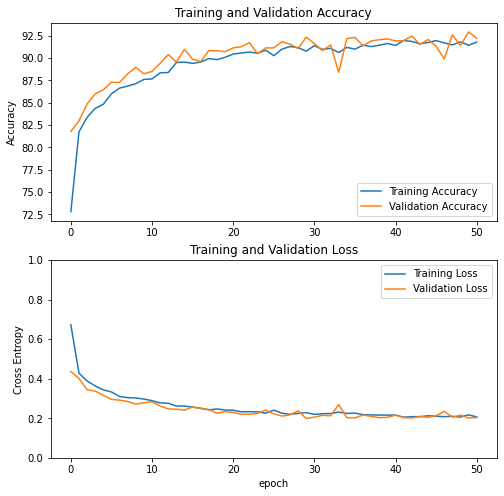

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [30]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [31]:
torch.save(model.state_dict(), '/kaggle/working/alexnet.pk1')

In [34]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('corn_model.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'corn_model.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'corn_model.pt')

/kaggle/working/corn_model.pt